# Project 2 - Consulting Project on Housing Data in King County, WA 

### Proposal to real estate developer in developing optimized house-building strategy

<br>

**Consultant Names:** Andy Nguyen, Juliet Day, Xibei(Julian) He <br>

**Date:** May 12, 2022



## Business Understanding

## Data Understanding

## Business Problem

### Import Packages

In [441]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.metrics import r2_score
from patsy import dmatrices


In [442]:
# Shows *all* columns in dataframe, i.e. does not truncate horizontally
pd.set_option('display.max_rows', None)

pd.set_option('display.max_columns', None)

# Converts from scientific notation to standard form (applied to every df in
# this notebook) and rounds to two decimal places
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Data Exploration and  Preparation

In [443]:
df = pd.read_csv('data/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0000,3,1.0000,1180,5650,1.0000,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0000,98178,47.5112,-122.2570,1340,5650
1,6414100192,12/9/2014,538000.0000,3,2.2500,2570,7242,2.0000,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0000,98125,47.7210,-122.3190,1690,7639
2,5631500400,2/25/2015,180000.0000,2,1.0000,770,10000,1.0000,NO,NONE,Average,6 Low Average,770,0.0,1933,nan,98028,47.7379,-122.2330,2720,8062
3,2487200875,12/9/2014,604000.0000,4,3.0000,1960,5000,1.0000,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0000,98136,47.5208,-122.3930,1360,5000
4,1954400510,2/18/2015,510000.0000,3,2.0000,1680,8080,1.0000,NO,NONE,Average,8 Good,1680,0.0,1987,0.0000,98074,47.6168,-122.0450,1800,7503


<AxesSubplot:xlabel='price'>

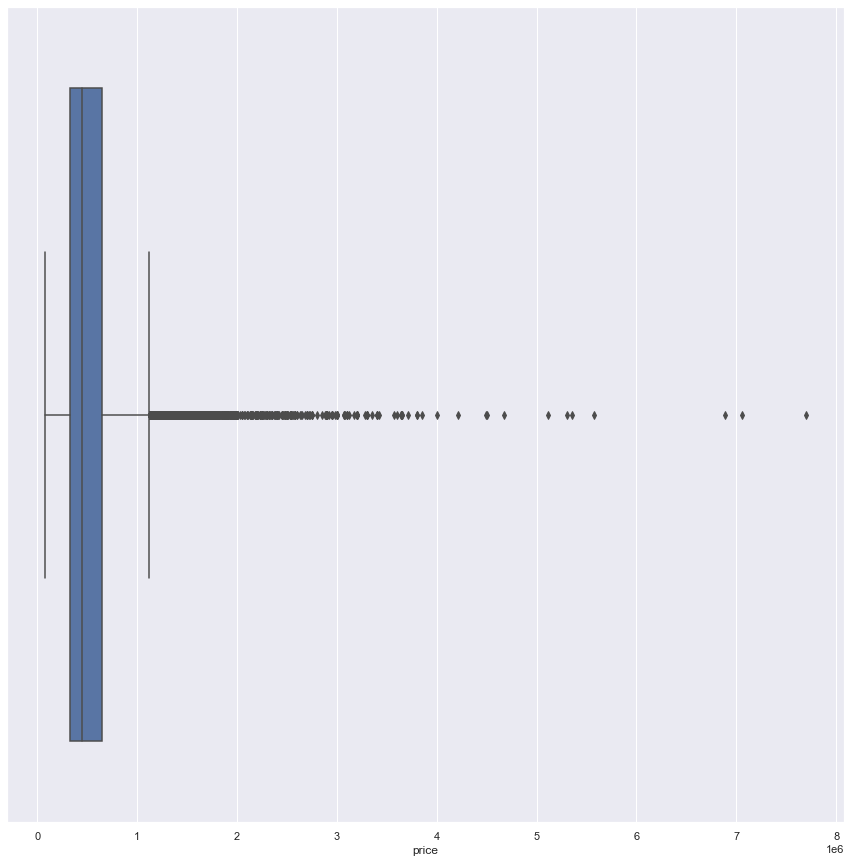

In [444]:
fig, ax = plt.subplots(figsize = (15, 15))
sns.boxplot(x= df["price"])

In [445]:
# make a copy and clean the data for modeling 
df_copy = df.copy()
df_copy = df_copy.drop_duplicates(subset= ['id'], keep = "last")
df_copy['grade'] = df_copy["grade"].str.split(" ").str[0].astype('int64')
df_copy = df_copy.loc[(df_copy['grade'] != 13) & (df_copy['grade'] != 3) & (df_copy["grade"] != 4)]
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Poor", '1'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Fair", '2'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Average", '3'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Very Good", '5'))
df_copy["condition"] = df_copy["condition"].apply(lambda x: x.replace("Good", '4'))
df_copy['condition'] = df_copy["condition"].astype("int64")
df_copy = df_copy.drop(['sqft_basement', 'yr_renovated', 'id', 'date', 'waterfront', 'view'], axis=1)

q3, q1 = np.percentile(df_copy['price'], [75, 25])
q3, q1
iqr = q3-q1
lower_limit = df_copy['price'].mean() - (iqr*1.5)
upper_limit = df_copy['price'].mean() + (iqr*1.5)
lower_limit, upper_limit

df_copy = df_copy[df_copy['price'] < upper_limit]

## Model Construction

## Linear Regression Assumptions Test Functions

### Linearity Test

In [446]:
# modified from Jeff Macaluso's code regarding linear assumption testing

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the dependent variable. 
    """
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.set(rc = {'figure.figsize':(12,10)})
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height = 9)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

### Normality Test

In [447]:
def normality(model, features, label):
    
    preds = model.predict(features)
    residuals = (label - preds)
    sns.set(rc = {'figure.figsize':(12,10)})
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True);
    
    return

###  Multicollinearity Test

In [448]:
def vif(features, label):
    
    label, features = dmatrices('label ~ features', data=training_data, return_type='dataframe')
    
    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = features.columns

    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

    return vif

###  Multicollinearity Test for New Model

In [449]:
def vif_new(feature, label):
    
    y, X = dmatrices('y ~ X', data=df_test, return_type='dataframe')
    
    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    
    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif = vif[vif['feature']!='intercept']

    return vif

In [450]:
def vif_second(feature, label):
    
    y, X = dmatrices('y ~ X', data=df_test2, return_type='dataframe')
    
    # make empty VIF dataframe
    vif = pd.DataFrame()
    vif["feature"] = X.columns
    
    # calculate VIF for each feature
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    vif = vif[vif['feature']!='intercept']

    return vif

### Homoscedasticity Test

In [451]:
def homoscedasticity(model, features, label):

    fig, ax = plt.subplots(figsize=(12, 10))

    
    preds = model.predict(features)
    residuals = (label - preds)
    
    ax.scatter(preds, residuals, alpha=0.5)
    ax.plot(preds, [0 for i in range(len(features))])
    ax.set_xlabel("Predicted Value")
    ax.set_ylabel("Actual - Predicted Value");

    return

## Build a baseline Model

In [452]:
training_data = df_copy.sample(frac = 0.75, random_state=25)
x_train = training_data.drop('price', axis=1)
y_train = training_data['price']

testing_data = df_copy.drop(training_data.index)
x_test = testing_data.drop('price', axis =1)
y_test = testing_data['price']

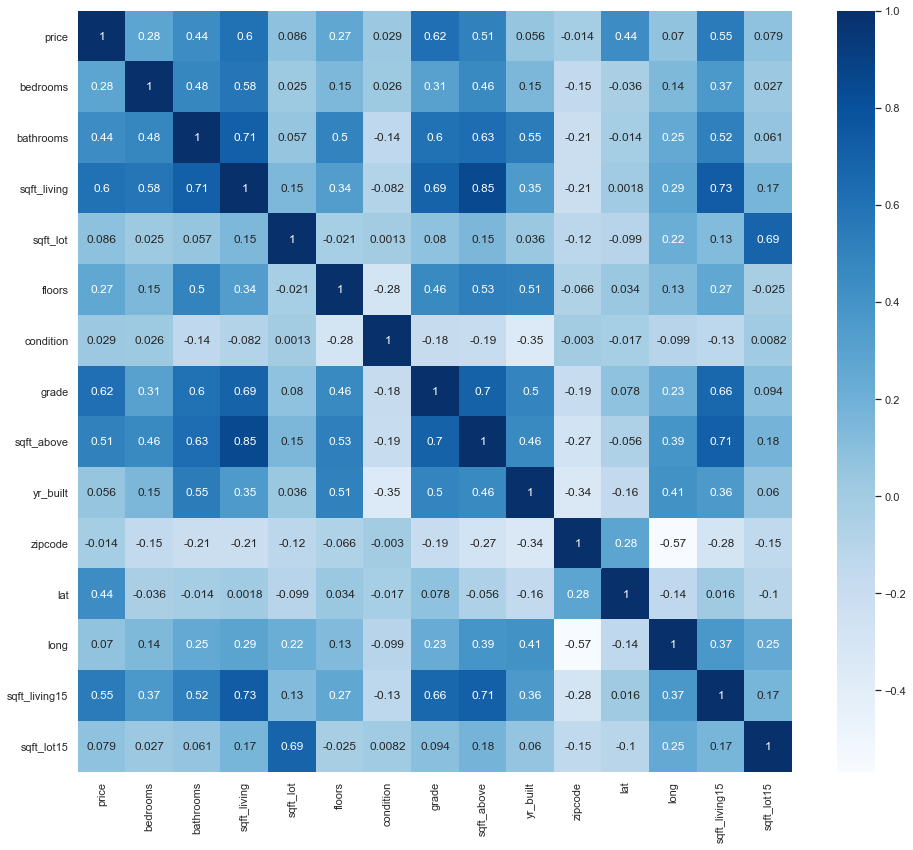

In [453]:
heatmap_data = pd.concat([y_train, x_train], axis=1)
corr = heatmap_data.corr()
sns.set(rc={'figure.figsize':(16, 14)})
sns.heatmap(data=corr, cmap="Blues", annot=True);

In [454]:
price_corrs = heatmap_data.corr()['price'].map(abs).sort_values(ascending=False)
price_corrs

price           1.0000
grade           0.6188
sqft_living     0.6046
sqft_living15   0.5495
sqft_above      0.5145
bathrooms       0.4403
lat             0.4379
bedrooms        0.2831
floors          0.2701
sqft_lot        0.0861
sqft_lot15      0.0791
long            0.0697
yr_built        0.0558
condition       0.0293
zipcode         0.0139
Name: price, dtype: float64

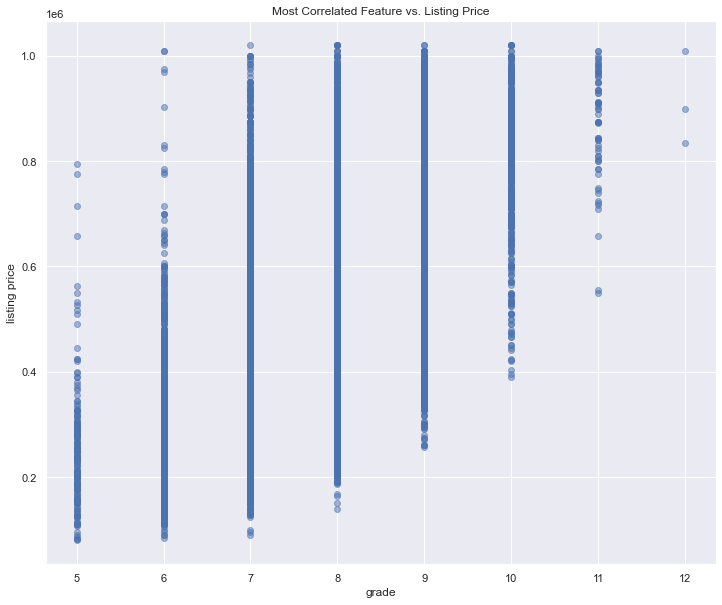

In [455]:
# Start with the simpliest variable grade and build our baseline model
most_correlated_feature = "grade"
fig, ax = plt.subplots(figsize=(12, 10))

ax.scatter(x_train[most_correlated_feature], y_train, alpha=0.5)
ax.set_xlabel(most_correlated_feature)
ax.set_ylabel("listing price")
ax.set_title("Most Correlated Feature vs. Listing Price");

In [456]:
baseline_model = LinearRegression()
splitter = ShuffleSplit(n_splits=3, test_size=0.75, random_state=0)

baseline_scores = cross_validate(
    estimator=baseline_model,
    X=x_train[[most_correlated_feature]],
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

baseline_model = LinearRegression()

# Fit the model on X_train_final and y_train
baseline_model = baseline_model.fit(x_train[[most_correlated_feature]], y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
# print("The test score is: ", baseline_model.score(x_test[[most_correlated_feature]], y_test))


Train score:      0.3854925641762302
Validation score: 0.381568978173713


### Running Assumption Tests on Baseline Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


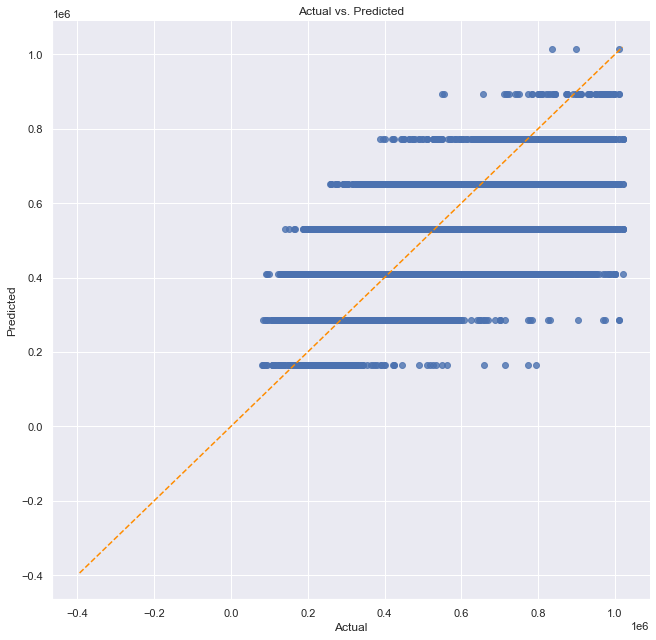

In [457]:
# becasue it is 
linear_assumption(baseline_model, x_train[[most_correlated_feature]], y_train)

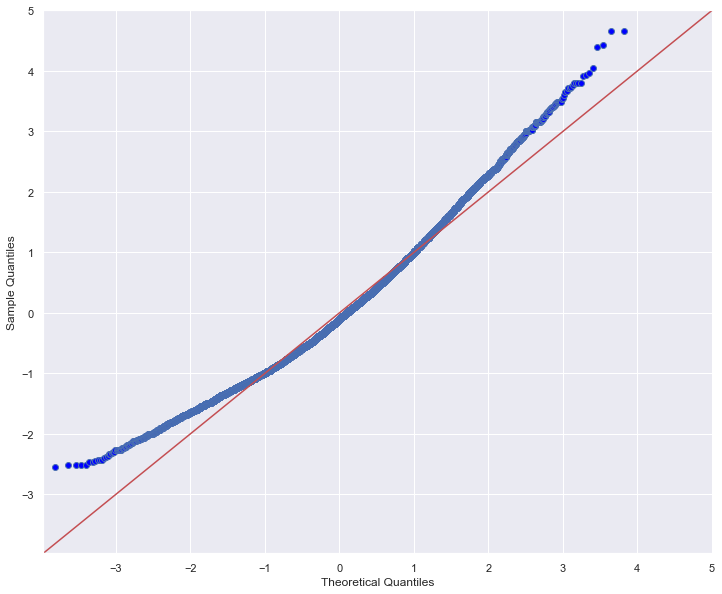

In [458]:
normality(baseline_model, x_train[[most_correlated_feature]], y_train)

We do not need to run multicollinearity and homoscedasticity tests on baseline model because it is a single variable regression.

Keep exploring the rest of columns.

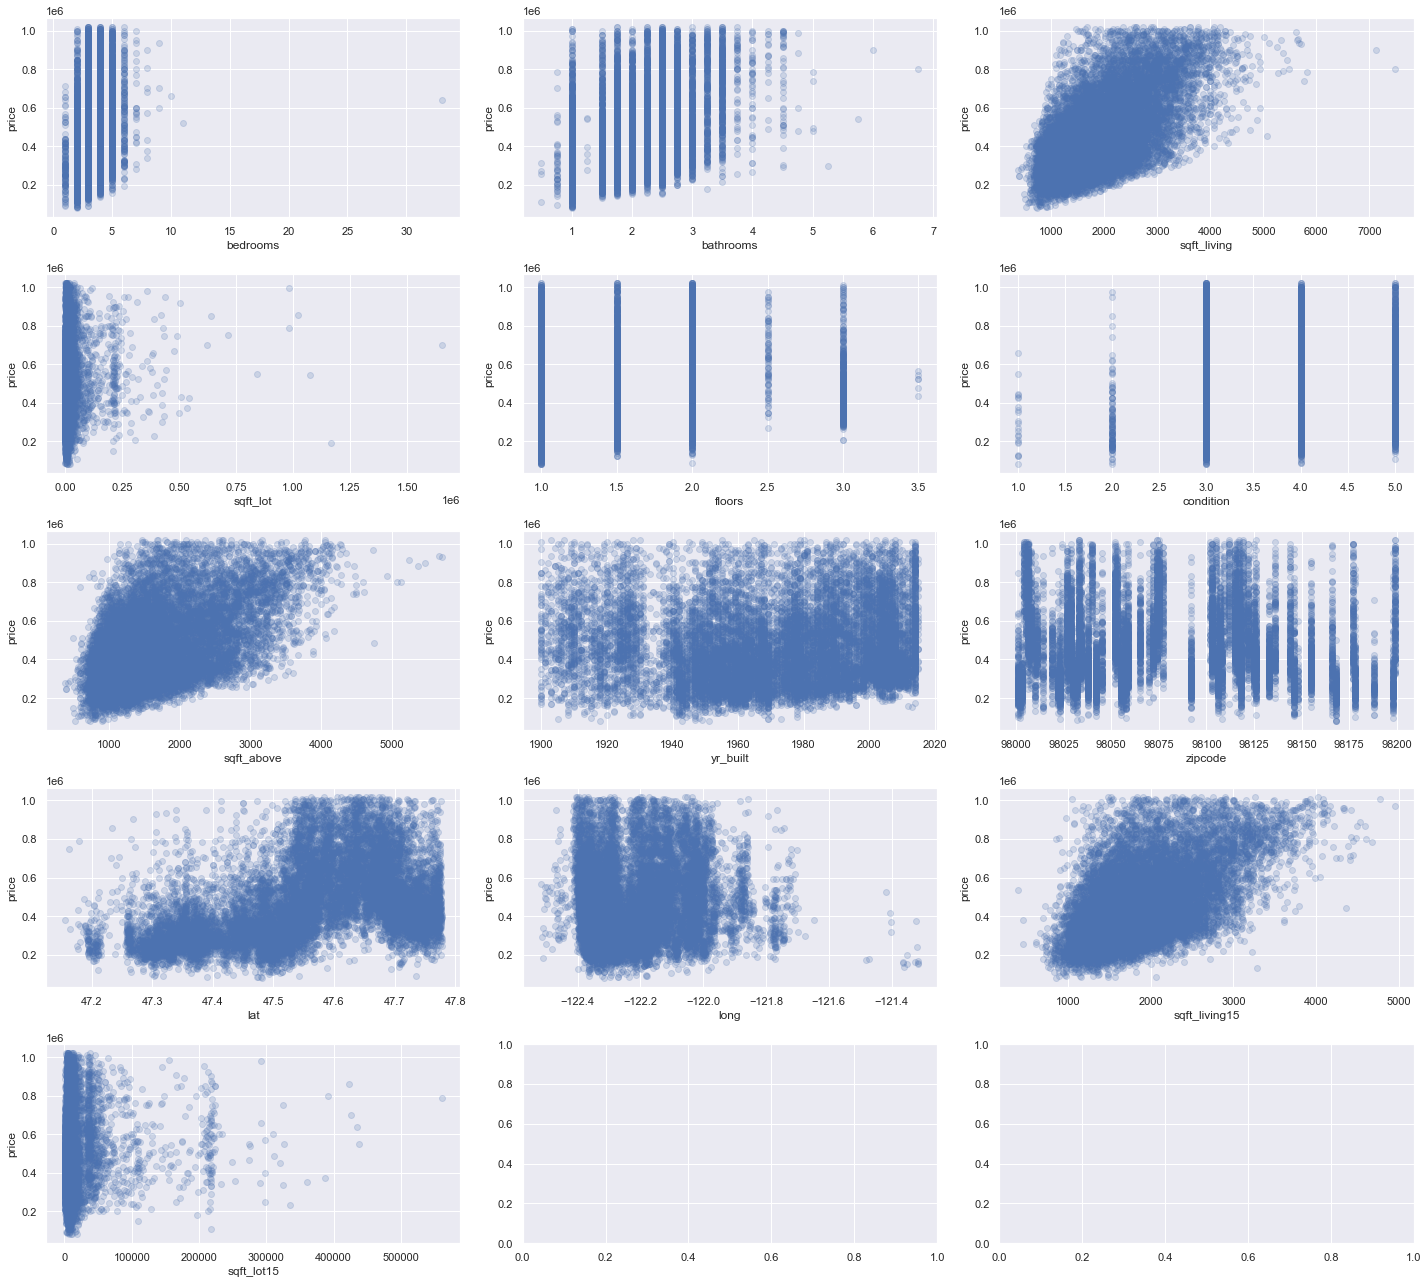

In [459]:
x_train_numeric = x_train.copy()
scatterplot_data = x_train_numeric.drop("grade", axis=1)

fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(20, 18))
fig.set_tight_layout(True)

for index, col in enumerate(scatterplot_data.columns):
    ax = axes[index//3][index%3]
    ax.scatter(x_train_numeric[col], y_train, alpha=0.2) 
    ax.set_xlabel(col)
    ax.set_ylabel("price")

### Running the second model

In [460]:
# based on heatmap, we dropped variables that have correlation over 0.7 with another independent variables to minimize 
# multicollinearity. 

x_train_second_model = x_train_numeric.drop('bathrooms', axis=1).copy()
x_train_second_model = x_train_second_model.drop('sqft_above', axis=1).copy()
x_train_second_model = x_train_second_model.drop('sqft_living15', axis=1).copy()
x_train_second_model.head(5)

,bedrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,lat,long,sqft_lot15
13434,4,1880,3720,1.5000,4,7,1924,98109,47.6431,-122.3560,4095
985,4,2130,8560,1.0000,3,7,1992,98022,47.1949,-122.0100,8560
3993,4,2530,5000,1.5000,5,8,1917,98103,47.6624,-122.3480,3600
10377,4,2390,9638,2.0000,3,10,1988,98029,47.5598,-122.0180,9258
847,3,4000,11894,1.0000,3,9,1987,98011,47.7738,-122.2030,8650


In [461]:
second_model = LinearRegression()
second_model = second_model.fit(x_train_second_model, y_train)

second_model_scores = cross_validate(
    estimator=second_model,
    X=x_train_second_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)
print("Current Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6693512695470417
Validation score: 0.6643748022712099

Baseline Model
Train score:      0.3854925641762302
Validation score: 0.381568978173713


### Running Assumption Tests on the 2nd Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


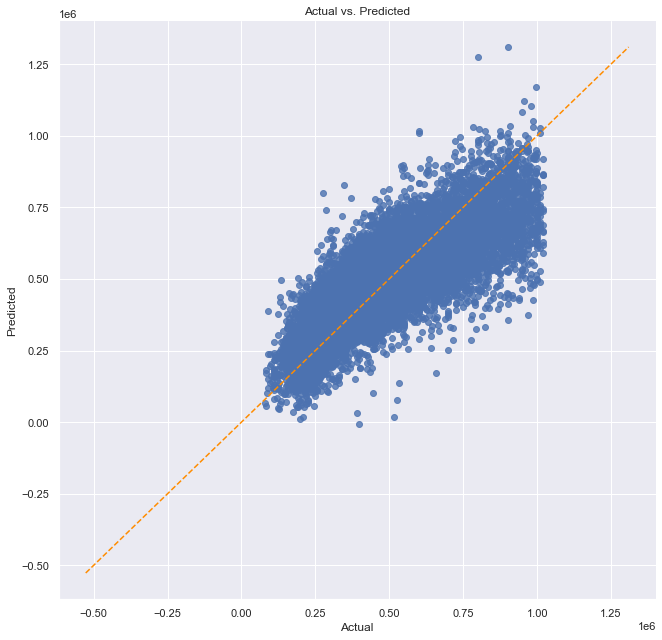

In [462]:
linear_assumption(second_model, x_train_second_model, y_train)

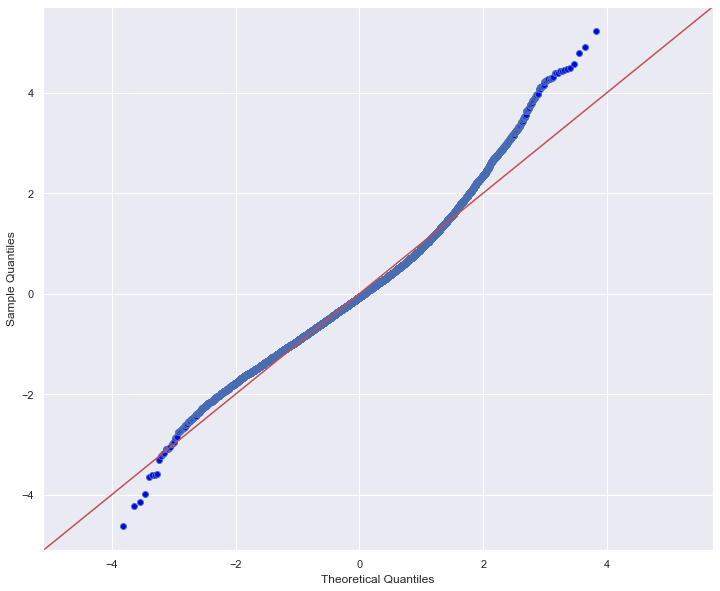

In [463]:
normality(second_model, x_train_second_model, y_train)

In [464]:
vif(x_train_second_model, y_train)

,feature,VIF
0,Intercept,4218701.6397
1,features[0],1.5725
2,features[1],2.8257
3,features[2],1.9110
4,features[3],1.5312
5,features[4],1.1909
6,features[5],2.4323
7,features[6],2.0118
8,features[7],1.6343
9,features[8],1.1505


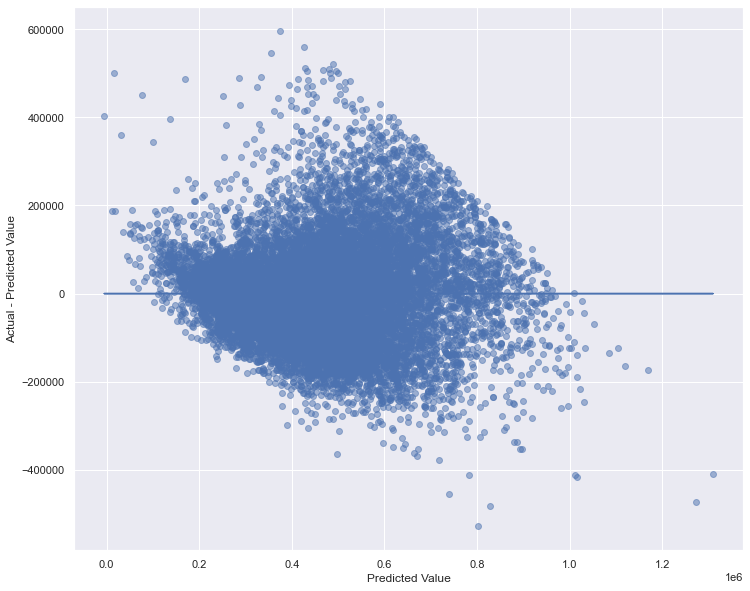

In [465]:
homoscedasticity(second_model, x_train_second_model, y_train)

#### Our 2nd model perform relatively well under assumtion tests, so the model has achieved statistical significance 
#### with R-squared = 66.4%. We will keep tuning our model to improve R-squared number. 

### Select the Best Combinations of Features

In [466]:
sm.OLS(y_train, sm.add_constant(x_train_second_model)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     2728.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        14:17:15   Log-Likelihood:            -1.9577e+05
No. Observations:               14986   AIC:                         3.916e+05
Df Residuals:                   14974   BIC:                         3.917e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.437e+06   1.92e+06     -3.361      0.001   -1.02e+07   -2.68e+06
bedrooms    -8925.0956   1281.490     -6.965      0.000   -1.14e+04   -6413.219
sqft_living   102.0327      2.070     49.295      0.000      97.976     106.090
sqft_lot        0.2057      0.031      6.635      0.000       0.145       0.266
floors       3.446e+04   2150.702     16.024      0.000    3.02e+04    3.87e+04
condition    2.407e+04   1570.391     15.329      0.000     2.1e+04    2.72e+04
grade        8.303e+04   1443.421     57.524      0.000    8.02e+04    8.59e+04
yr_built    -1748.0985     45.445    -38.466      0.000   -1837.177   -1659.020
zipcode      -195.7649     22.343     -8.762      0.000    -239.559    -151.971
lat          5.252e+05   7055.513     74.432      0.000    5.11e+05    5.39e+05
long        -2.985e+04   8567.356     -3.485      0.000   -4.66e+04   -1.31e+04
sqft_lot15     -0.0185      0.050     -0.368      0.713      -0.117       0.080
==============================================================================
Omnibus:                     1146.033   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1878.548
Skew:                           0.585   Prob(JB):                         0.00
Kurtosis:                       4.280   Cond. No.                     2.06e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Run the 3rd Model

In [467]:
# drop p-value > 0.05, so sqft_lot15 will be dropped.

significant_features = ['bedrooms', 'sqft_living', 'sqft_lot', 'floors', 
                        'condition', 'grade', 'yr_built', 'zipcode', 'lat', 'long'] 
third_model = LinearRegression()
x_train_third_model = x_train[significant_features]

third_model_scores = cross_validate(
    estimator=third_model,
    X=x_train_third_model,
    y=y_train,
    return_train_score=True,
    cv=splitter
)

print("Current Model")
print("Train score:     ", third_model_scores["train_score"].mean())
print("Validation score:", third_model_scores["test_score"].mean())
print()
print("Second Model")
print("Train score:     ", second_model_scores["train_score"].mean())
print("Validation score:", second_model_scores["test_score"].mean())
print()
print("Baseline Model")
print("Train score:     ", baseline_scores["train_score"].mean())
print("Validation score:", baseline_scores["test_score"].mean())

Current Model
Train score:      0.6691562834412729
Validation score: 0.6646815390133285

Second Model
Train score:      0.6693512695470417
Validation score: 0.6643748022712099

Baseline Model
Train score:      0.3854925641762302
Validation score: 0.381568978173713


### RFE approach

In [468]:
# Importances are based on coefficient magnitude, so
# we need to scale the data to normalize the coefficients
x_train_for_RFECV = StandardScaler().fit_transform(x_train_third_model)

model_for_RFECV = LinearRegression()

# Instantiate and fit the selector
selector = RFECV(model_for_RFECV, cv=splitter)
selector.fit(x_train_for_RFECV, y_train)

# Print the results
print("Was the column selected?")
for index, col in enumerate(x_train_third_model.columns):
    print(f"{col}: {selector.support_[index]}")

Was the column selected?
bedrooms: True
sqft_living: True
sqft_lot: True
floors: True
condition: True
grade: True
yr_built: True
zipcode: True
lat: True
long: True


In [469]:
best_features = significant_features
x_train_final = x_train[best_features]
x_test_final = x_test[best_features]

final_model = LinearRegression()

# Fit the model on X_train_final and y_train
final_model = final_model.fit(x_train_final, y_train)

# Score the model on X_test_final and y_test
# (use the built-in .score method)
print("The test score is: ", final_model.score(x_test_final, y_test))
print("The RMSE for the test is: ", mean_squared_error(y_test, final_model.predict(x_test_final), squared=False))

The test score is:  0.6717980155783607
The RMSE for the test is:  112243.7457638945


In [470]:
print(pd.Series(final_model.coef_, index=x_train_final.columns, name="Coefficients"))
print()
print("Intercept:", final_model.intercept_)

bedrooms       -8896.8970
sqft_living      101.9685
sqft_lot           0.1982
floors         34498.7206
condition      24063.6969
grade          83035.5763
yr_built       -1748.0459
zipcode         -195.8071
lat           525249.1128
long          -30184.4161
Name: Coefficients, dtype: float64

Intercept: -6477958.174080452


### Running Assumption Tests For the Final Model Before One Hot Encoder

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


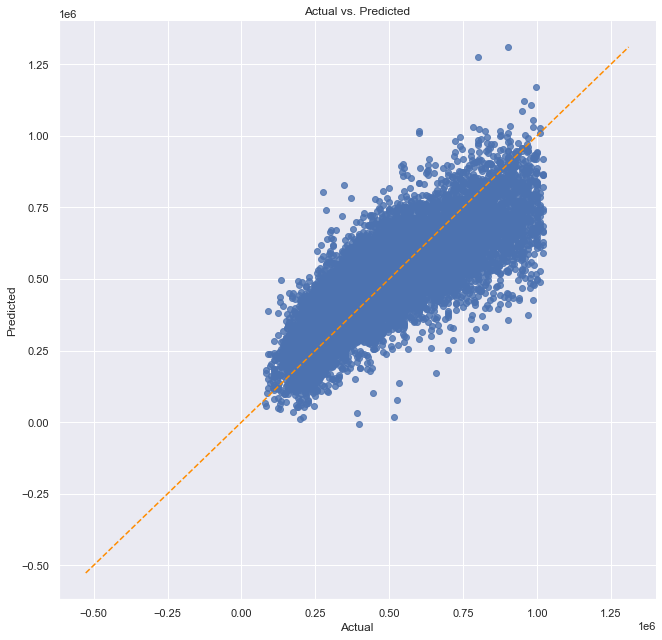

In [471]:
linear_assumption(final_model, x_train_final, y_train)

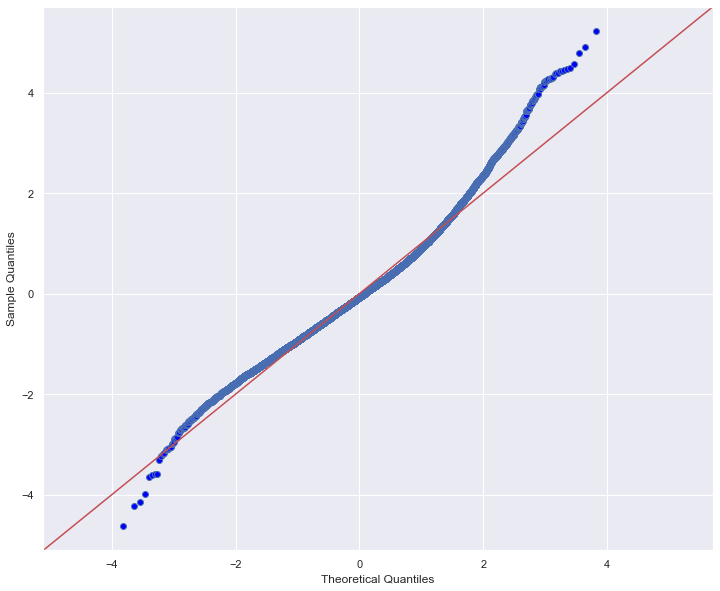

In [472]:
normality(final_model, x_train_final, y_train)

In [473]:
vif(x_train_final, y_train)

,feature,VIF
0,Intercept,4204604.2350
1,features[0],1.5668
2,features[1],2.8056
3,features[2],1.0847
4,features[3],1.5281
5,features[4],1.1906
6,features[5],2.4321
7,features[6],2.0117
8,features[7],1.6342
9,features[8],1.1490


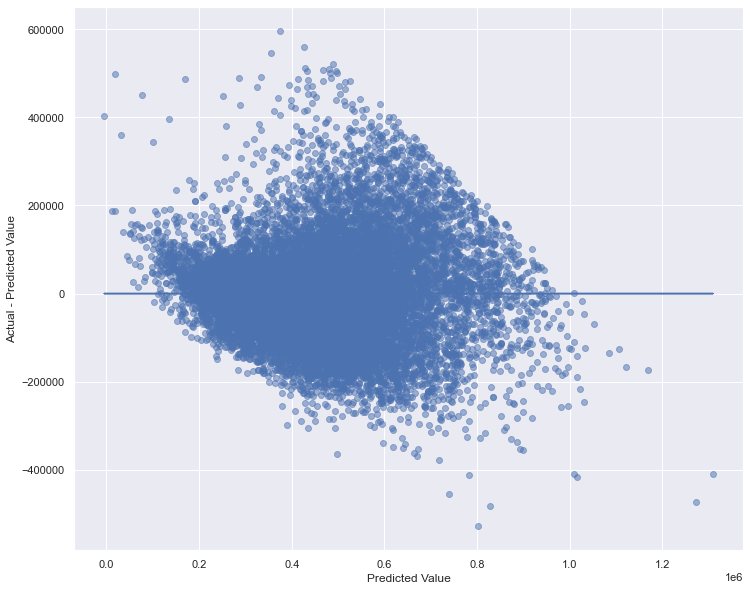

In [474]:
homoscedasticity(final_model, x_train_final, y_train)

#### Expecting One Hot Encoder to Further Improve R-squared

### Apply One Hot Encoder to Zipcode

In [476]:
# create this new datatable for modeling use later. 
df_comb = pd.concat([x_train_final, y_train], axis=1)
df_comb.head(10)

,bedrooms,sqft_living,sqft_lot,floors,condition,grade,yr_built,zipcode,lat,long,price
13434,4,1880,3720,1.5000,4,7,1924,98109,47.6431,-122.3560,860000.0000
985,4,2130,8560,1.0000,3,7,1992,98022,47.1949,-122.0100,283000.0000
3993,4,2530,5000,1.5000,5,8,1917,98103,47.6624,-122.3480,720000.0000
10377,4,2390,9638,2.0000,3,10,1988,98029,47.5598,-122.0180,645500.0000
847,3,4000,11894,1.0000,3,9,1987,98011,47.7738,-122.2030,628000.0000
609,4,3100,15842,2.0000,3,8,1996,98028,47.7466,-122.2420,590000.0000
7608,3,1100,1307,2.0000,3,7,2008,98106,47.5601,-122.3630,285000.0000
2664,4,3030,9687,2.0000,3,8,1998,98045,47.4850,-121.7990,471000.0000
10253,4,3310,4500,2.5000,5,9,1900,98103,47.6594,-122.3450,829000.0000
13632,4,2600,8572,2.0000,3,8,2003,98001,47.3155,-122.2660,300000.0000


We created this new datatable to see how the last model react after combined with one hot encoder, but now let's focus on
a new test from scratch with one hot encoder. 

In [477]:
df_test = df_copy.copy()
df_test = df_test.reset_index()
encoder = OneHotEncoder()

zipcode_trans = encoder.fit_transform(df_test['zipcode'].values.reshape(-1,1))
zipcode_trans.todense()
encoder.get_feature_names()
zipcode_df =pd.DataFrame(zipcode_trans.todense(), columns = encoder.get_feature_names())
zipcode_df
df_test = df_test.join(zipcode_df)
df_test = df_test.drop('index', axis=1)

endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     1115.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        14:21:31   Log-Likelihood:            -2.5477e+05
No. Observations:               19981   AIC:                         5.097e+05
Df Residuals:                   19898   BIC:                         5.104e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.433e+07   3.25e+06     -4.405      0.000   -2.07e+07   -7.95e+06
bedrooms      -4451.8301    852.827     -5.220      0.000   -6123.443   -2780.217
bathrooms      1.653e+04   1457.828     11.341      0.000    1.37e+04    1.94e+04
sqft_living      66.8087      2.076     32.183      0.000      62.740      70.878
sqft_lot          0.2999      0.021     14.284      0.000       0.259       0.341
floors        -1.333e+04   1742.083     -7.654      0.000   -1.67e+04   -9919.129
condition       2.18e+04   1035.452     21.052      0.000    1.98e+04    2.38e+04
grade          4.455e+04   1030.139     43.248      0.000    4.25e+04    4.66e+04
sqft_above       38.4093      2.099     18.296      0.000      34.294      42.524
yr_built       -670.3540     34.019    -19.705      0.000    -737.034    -603.674
lat            1.492e+05   3.42e+04      4.365      0.000    8.22e+04    2.16e+05
long          -7.002e+04   2.43e+04     -2.877      0.004   -1.18e+05   -2.23e+04
sqft_living15    42.0605      1.687     24.932      0.000      38.754      45.367
sqft_lot15        0.0114      0.033      0.344      0.731      -0.053       0.076
x0_98001        -3.5e+05   4.51e+04     -7.757      0.000   -4.38e+05   -2.62e+05
x0_98002        -3.4e+05    4.4e+04     -7.730      0.000   -4.26e+05   -2.54e+05
x0_98003      -3.576e+05   4.61e+04     -7.754      0.000   -4.48e+05   -2.67e+05
x0_98004       8.819e+04   4.77e+04      1.850      0.064   -5253.394    1.82e+05
x0_98005      -7.316e+04   4.69e+04     -1.559      0.119   -1.65e+05    1.88e+04
x0_98006      -1.173e+05   4.55e+04     -2.580      0.010   -2.06e+05   -2.82e+04
x0_98007      -1.419e+05   4.65e+04     -3.053      0.002   -2.33e+05   -5.08e+04
x0_98008       -1.46e+05   4.58e+04     -3.189      0.001   -2.36e+05   -5.63e+04
x0_98010      -2.516e+05      4e+04     -6.296      0.000    -3.3e+05   -1.73e+05
x0_98011      -2.741e+05      5e+04     -5.477      0.000   -3.72e+05   -1.76e+05
x0_98014      -2.689e+05   4.22e+04     -6.374      0.000   -3.52e+05   -1.86e+05
x0_98019      -2.957e+05   4.51e+04     -6.549      0.000   -3.84e+05   -2.07e+05
x0_98022      -3.058e+05   3.82e+04     -8.001      0.000   -3.81e+05   -2.31e+05
x0_98023      -3.807e+05   4.72e+04     -8.066      0.000   -4.73e+05   -2.88e+05
x0_98024      -2.162e+05   4.15e+04     -5.208      0.000   -2.98e+05   -1.35e+05
x0_98027      -1.823e+05   4.27e+04     -4.270      0.000   -2.66e+05   -9.86e+04
x0_98028      -2.844e+05   5.08e+04     -5.598      0.000   -3.84e+05   -1.85e+05
x0_98029      -1.464e+05   4.26e+04     -3.439      0.001    -2.3e+05    -6.3e+04
x0_98030      -3.512e+05    4.4e+04     -7.986      0.000   -4.37e+05   -2.65e+05
x0_98031      -3.522e+05   4.43e+04     -7.946      0.000   -4.39e+05   -2.65e+05
x0_98032       -3.68e+05   4.63e+04     -7.945   

Notice that the condition number is very big in this model, and we are sure that there is multicollinearity problem.
We are going to drop these variables with large p-value and see if it improves the model overall without sacrificing 
too much of predictive power. 

### Test score on our new model with One Hot Encoder

In [371]:
# Compute our model test score. The score is great, but we need to check if our model is reliable enough to provdie 
# statisticlly significant result.

X = df_test.drop('price', axis = 1)
y = df_test.price
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8272653880964705
0.8278781334640103


In [372]:
# Calculate the RMSE measure.
lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

83401.76021945407
83401.76021945442


### Assumption Tests with New Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


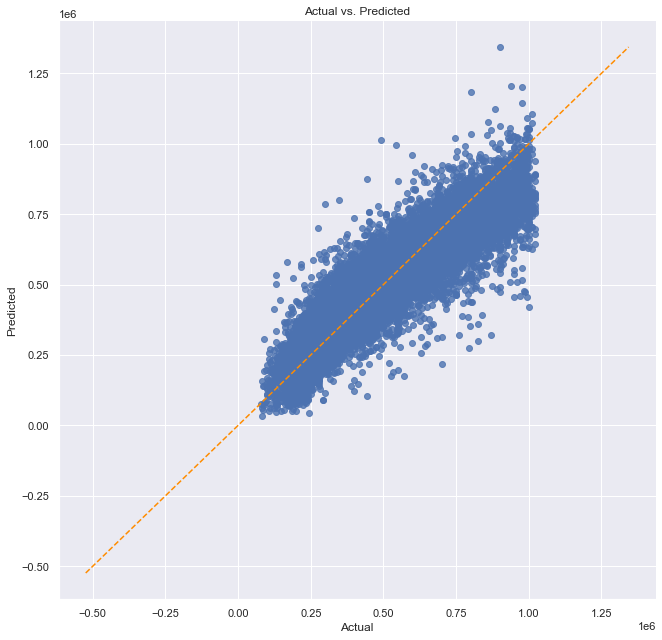

In [373]:
linear_assumption(lr, X, y)

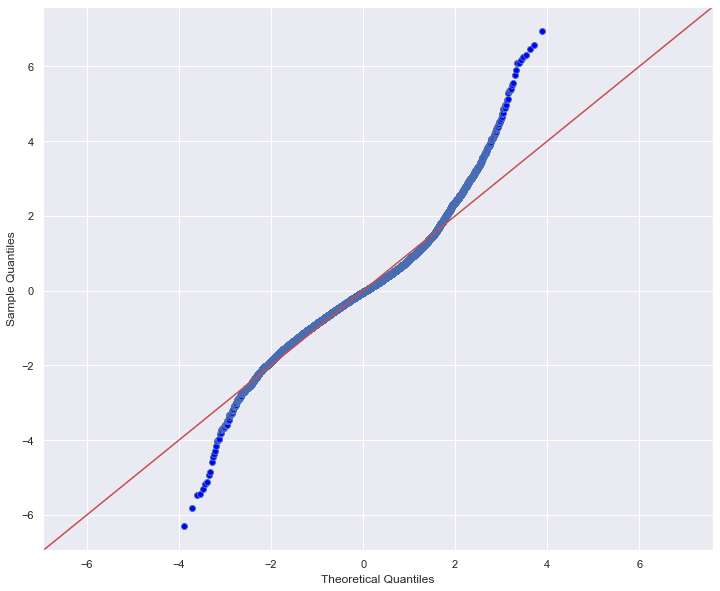

In [374]:
normality(lr, X, y)

In [375]:
# It seems that we are seeing some zeros that cause inf problem. It's not a big deal as we will tune our model and make it 
# more reliable.
vif_new(X, y)

C:\Users\Trader\anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Trader\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,Intercept,0.0000
1,X[0],1.7008
2,X[1],2.9944
3,X[2],7.0523
4,X[3],2.0329
5,X[4],2.5013
6,X[5],1.2762
7,X[6],3.0736
8,X[7],6.4046
9,X[8],2.8086


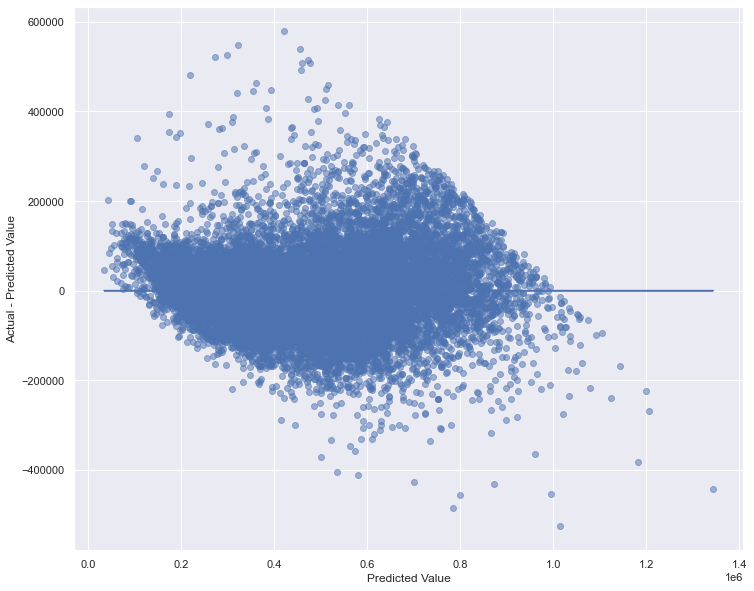

In [376]:
homoscedasticity(lr, X, y)

We are dropping the variables with P-Value > 0.05 and see if the model is improving.

In [377]:
endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode', 'sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     1288.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        14:04:01   Log-Likelihood:            -2.5525e+05
No. Observations:               19981   AIC:                         5.106e+05
Df Residuals:                   19913   BIC:                         5.112e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.356e+06   2.33e+06      3.586      0.000    3.79e+06    1.29e+07
bedrooms      -4059.1798    871.264     -4.659      0.000   -5766.929   -2351.431
bathrooms      1.628e+04   1489.974     10.924      0.000    1.34e+04    1.92e+04
sqft_living      65.3747      2.118     30.869      0.000      61.224      69.526
sqft_lot          0.2954      0.017     17.829      0.000       0.263       0.328
floors        -1.431e+04   1735.781     -8.244      0.000   -1.77e+04   -1.09e+04
condition      2.172e+04   1053.625     20.618      0.000    1.97e+04    2.38e+04
grade          4.559e+04   1048.394     43.481      0.000    4.35e+04    4.76e+04
sqft_above       37.0767      2.138     17.345      0.000      32.887      41.267
yr_built       -692.8202     33.912    -20.430      0.000    -759.291    -626.349
lat           -5.996e+04   2.53e+04     -2.369      0.018    -1.1e+05   -1.04e+04
long            3.43e+04   1.63e+04      2.106      0.035    2371.784    6.62e+04
sqft_living15    47.4486      1.702     27.873      0.000      44.112      50.785
x0_98001      -3.541e+05   9844.179    -35.975      0.000   -3.73e+05   -3.35e+05
x0_98002      -3.488e+05   1.08e+04    -32.412      0.000    -3.7e+05   -3.28e+05
x0_98003      -3.571e+05   9983.515    -35.767      0.000   -3.77e+05   -3.38e+05
x0_98006      -8.535e+04   5702.132    -14.967      0.000   -9.65e+04   -7.42e+04
x0_98007      -9.849e+04   8083.155    -12.184      0.000   -1.14e+05   -8.26e+04
x0_98008       -1.04e+05   6303.806    -16.502      0.000   -1.16e+05   -9.17e+04
x0_98010      -2.788e+05   1.28e+04    -21.823      0.000   -3.04e+05   -2.54e+05
x0_98011       -1.94e+05   7166.661    -27.075      0.000   -2.08e+05    -1.8e+05
x0_98014        -2.4e+05    1.1e+04    -21.804      0.000   -2.62e+05   -2.18e+05
x0_98019      -2.431e+05   8848.219    -27.477      0.000    -2.6e+05   -2.26e+05
x0_98022      -3.584e+05   1.34e+04    -26.787      0.000   -3.85e+05   -3.32e+05
x0_98023      -3.763e+05   9619.979    -39.113      0.000   -3.95e+05   -3.57e+05
x0_98024      -2.067e+05   1.24e+04    -16.646      0.000   -2.31e+05   -1.82e+05
x0_98027      -1.676e+05   6960.364    -24.083      0.000   -1.81e+05   -1.54e+05
x0_98028      -1.992e+05   6142.138    -32.436      0.000   -2.11e+05   -1.87e+05
x0_98029      -1.269e+05   7368.798    -17.217      0.000   -1.41e+05   -1.12e+05
x0_98030      -3.515e+05   9182.570    -38.278      0.000   -3.69e+05   -3.33e+05
x0_98031      -3.455e+05   8408.703    -41.086      0.000   -3.62e+05   -3.29e+05
x0_98032      -3.581e+05   1.05e+04    -34.018      0.000   -3.79e+05   -3.37e+05
x0_98034      -1.502e+05   4801.522    -31.286      0.000    -1.6e+05   -1.41e+05
x0_98038      -3.224e+05   9085.585    -35.489      0.000    -3.4e+05   -3.05e+05
x0_98039       2.803e+05   3.83e+04      7.312   

The condition number has definitely improved. However, it is still show the multicollinearity problem.

In [378]:
y = df_test.price
X = df_test.drop(labels=['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                         'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                         'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

0.8231986382335483
0.8219348743905902


In [379]:
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199'], axis = 1)
y = df_test.price

lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
print(np.sqrt(mean_squared_error(y, y_hat)))

85433.65982736617
85433.65982736605


### Running Assumption Tests on the Improved Model

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


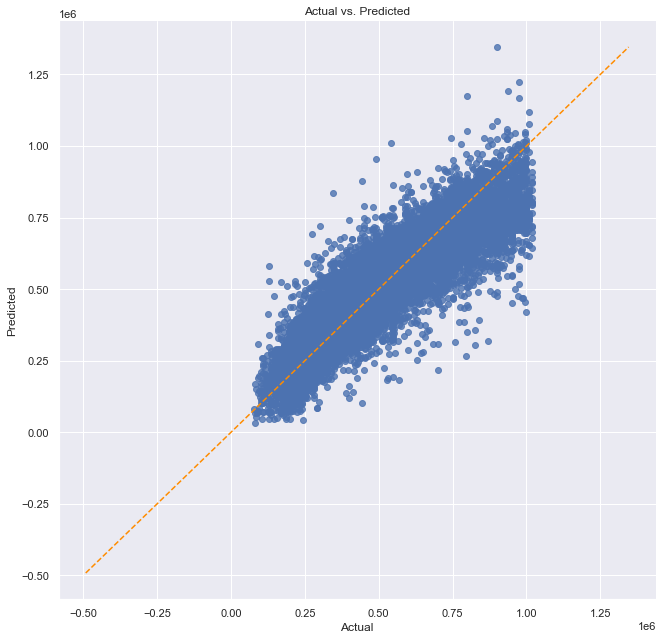

In [380]:
linear_assumption(lr, X, y)

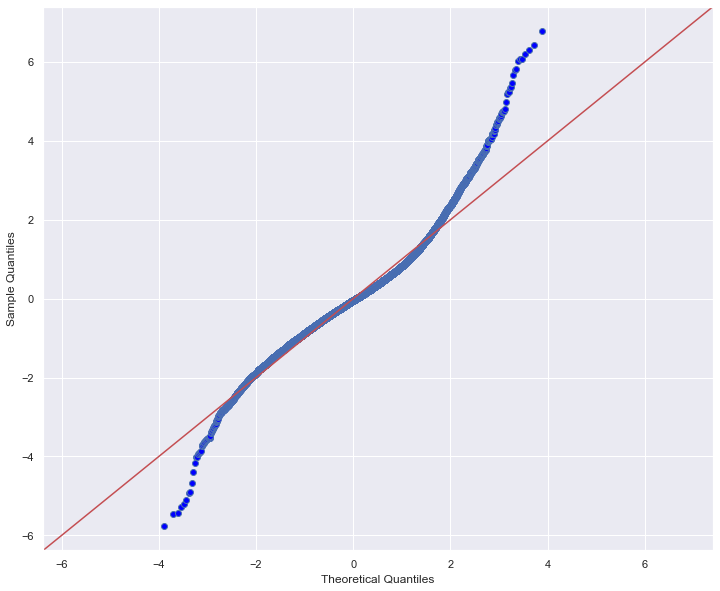

In [381]:
normality(lr, X, y)

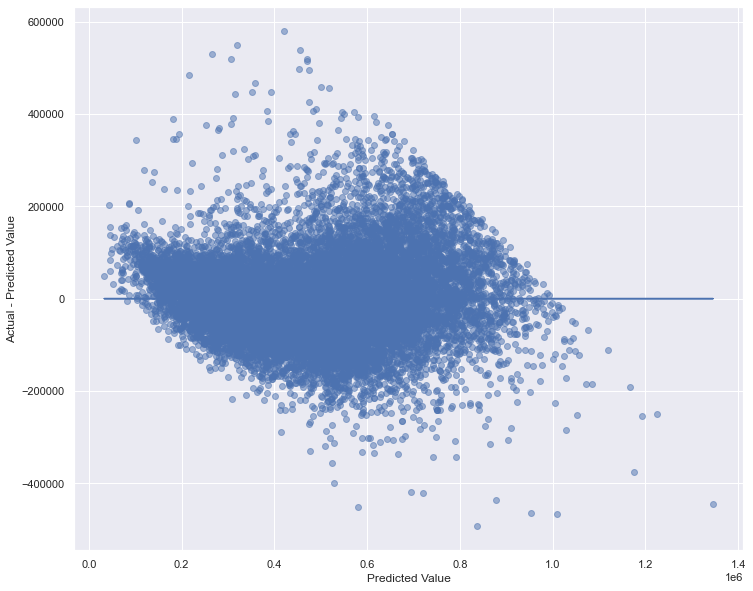

In [382]:
homoscedasticity(lr, X, y)

#### Handling the Multicollinearity Problem

In [383]:
vif_new(X,y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,14809867.6127
10,X[9],35.0522
11,X[10],14.6876
3,X[2],7.0004
33,X[32],6.3793
8,X[7],6.3333
24,X[23],6.0278
23,X[22],5.6053
35,X[34],5.4483
49,X[48],4.8945


In [384]:
# Since we have mullticollinearity problem that is reflected on VIF scores. Instead of dropping them altogether, we started by
# dropping the variable with the highest vif score one by one. In this way, we can see how model reacts without remove 
# significant variable.

X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 'lat', 'long'], axis = 1)
vif_new(X,y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,11106.9456
3,X[2],6.9784
8,X[7],6.2432
7,X[6],3.0208
2,X[1],2.9805
10,X[9],2.8351
9,X[8],2.5955
5,X[4],2.3053
1,X[0],1.6901
31,X[30],1.3115


In [385]:
# VIF has come out great, and we have reached our best model.
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 
                  'lat', 'long', 'sqft_above'], axis = 1)
vif_new(X,y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,11086.9902
3,X[2],4.3658
7,X[6],2.9506
2,X[1],2.8991
9,X[8],2.7708
8,X[7],2.5850
5,X[4],1.7660
1,X[0],1.6898
30,X[29],1.2718
6,X[5],1.2479


In [493]:
#checking the predicative capability of our ultimate model.

y = df_test.price
X = df_test.drop(labels=['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                         'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                         'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199',
                         'lat', 'long', 'sqft_above'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr = LinearRegression()
lr.fit(x_train, y_train)
print(lr.score(x_train, y_train))
result = print(lr.score(x_test, y_test))

0.8216826231858102
0.8198428041130621


In [497]:
X = df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                  'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                  'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199',
                  'lat', 'long', 'sqft_above'], axis = 1)
y = df_test.price

lr = LinearRegression()
lr.fit(X,y)
                  
y_hat= lr.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
result_rmse = print(np.sqrt(mean_squared_error(y, y_hat)))

86126.83160375278
86126.83160375283


In [389]:
# checking our conditional no. from this model.
endog = df_test["price"]
exog = sm.add_constant(df_test.drop(['price', 'zipcode','sqft_lot15', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98103', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98122', 'x0_98199', 
                                    'lat', 'long','sqft_above'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     1322.
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        14:04:22   Log-Likelihood:            -2.5541e+05
No. Observations:               19981   AIC:                         5.109e+05
Df Residuals:                   19916   BIC:                         5.115e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.329e+06   6.43e+04     20.676      0.000     1.2e+06    1.45e+06
bedrooms      -3772.2740    877.451     -4.299      0.000   -5492.152   -2052.396
bathrooms      1.185e+04   1480.638      8.002      0.000    8946.252    1.48e+04
sqft_living      88.0100      1.686     52.203      0.000      84.705      91.315
sqft_lot          0.3047      0.017     18.280      0.000       0.272       0.337
floors         -292.6382   1510.961     -0.194      0.846   -3254.248    2668.972
condition      2.065e+04   1056.901     19.538      0.000    1.86e+04    2.27e+04
grade          4.828e+04   1041.821     46.345      0.000    4.62e+04    5.03e+04
yr_built       -718.9290     33.687    -21.341      0.000    -784.959    -652.899
sqft_living15    52.4820      1.687     31.107      0.000      49.175      55.789
x0_98001      -3.225e+05   4905.794    -65.732      0.000   -3.32e+05   -3.13e+05
x0_98002      -3.122e+05   6407.888    -48.715      0.000   -3.25e+05      -3e+05
x0_98003       -3.29e+05   5471.972    -60.133      0.000    -3.4e+05   -3.18e+05
x0_98006      -7.126e+04   4791.850    -14.872      0.000   -8.07e+04   -6.19e+04
x0_98007      -8.286e+04   7692.565    -10.772      0.000   -9.79e+04   -6.78e+04
x0_98008      -8.827e+04   5583.417    -15.809      0.000   -9.92e+04   -7.73e+04
x0_98010      -2.362e+05   8942.632    -26.414      0.000   -2.54e+05   -2.19e+05
x0_98011      -1.893e+05   6467.565    -29.269      0.000   -2.02e+05   -1.77e+05
x0_98014      -2.141e+05   8313.745    -25.750      0.000    -2.3e+05   -1.98e+05
x0_98019      -2.257e+05   6576.295    -34.325      0.000   -2.39e+05   -2.13e+05
x0_98022      -3.085e+05   6038.660    -51.084      0.000    -3.2e+05   -2.97e+05
x0_98023      -3.502e+05   4284.176    -81.739      0.000   -3.59e+05   -3.42e+05
x0_98024      -1.753e+05   1.05e+04    -16.649      0.000   -1.96e+05   -1.55e+05
x0_98027      -1.471e+05   4759.855    -30.910      0.000   -1.56e+05   -1.38e+05
x0_98028      -1.975e+05   5451.274    -36.228      0.000   -2.08e+05   -1.87e+05
x0_98029      -1.026e+05   5242.898    -19.565      0.000   -1.13e+05   -9.23e+04
x0_98030        -3.2e+05   5721.479    -55.935      0.000   -3.31e+05   -3.09e+05
x0_98031      -3.179e+05   5550.418    -57.273      0.000   -3.29e+05   -3.07e+05
x0_98032      -3.349e+05   7997.077    -41.874      0.000   -3.51e+05   -3.19e+05
x0_98034      -1.441e+05   4169.277    -34.566      0.000   -1.52e+05   -1.36e+05
x0_98038      -2.844e+05   4089.261    -69.550      0.000   -2.92e+05   -2.76e+05
x0_98039       2.856e+05   3.86e+04      7.394      0.000     2.1e+05    3.61e+05
x0_98042       -3.15e+05   4149.371    -75.913      0.000   -3.23e+05   -3.07e+05
x0_98045      -2.105e+05   6217.081    -33.857      0.000   -2.23e+05   -1.98e+05
x0_98052      -8.067e+04   4087.041    -19.739   

In [396]:
x_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14986 entries, 13434 to 11709
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bedrooms     14986 non-null  int64  
 1   sqft_living  14986 non-null  int64  
 2   sqft_lot     14986 non-null  int64  
 3   floors       14986 non-null  float64
 4   condition    14986 non-null  int64  
 5   grade        14986 non-null  int64  
 6   yr_built     14986 non-null  int64  
 7   zipcode      14986 non-null  int64  
 8   lat          14986 non-null  float64
 9   long         14986 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 1.9 MB


#### Now let's combine our final model(without one hot) with one hot encoder

In [505]:
df_test2 = df_comb.copy()
df_test2 = df_test2.reset_index()
encoder = OneHotEncoder()

zipcode_trans = encoder.fit_transform(df_test2['zipcode'].values.reshape(-1,1))
zipcode_trans.todense()
encoder.get_feature_names()
zipcode_df =pd.DataFrame(zipcode_trans.todense(), columns = encoder.get_feature_names())
zipcode_df
df_test2 = df_test2.join(zipcode_df)
df_test2 = df_test2.drop('index', axis=1)

endog = df_test2["price"]
exog = sm.add_constant(df_test2.drop(['price', 'zipcode'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     816.8
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        15:02:47   Log-Likelihood:            -1.9156e+05
No. Observations:               14986   AIC:                         3.833e+05
Df Residuals:                   14907   BIC:                         3.839e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.418e+07   3.73e+06     -3.807      0.000   -2.15e+07   -6.88e+06
bedrooms    -5334.8410    981.618     -5.435      0.000   -7258.933   -3410.749
sqft_living   113.7940      1.599     71.175      0.000     110.660     116.928
sqft_lot        0.3113      0.018     16.850      0.000       0.275       0.347
floors       3732.7789   1777.260      2.100      0.036     249.130    7216.427
condition    1.936e+04   1218.010     15.897      0.000     1.7e+04    2.18e+04
grade        5.561e+04   1159.401     47.964      0.000    5.33e+04    5.79e+04
yr_built     -666.0235     37.776    -17.631      0.000    -740.070    -591.977
lat          1.904e+05   4.09e+04      4.655      0.000     1.1e+05    2.71e+05
long        -5.261e+04   2.73e+04     -1.926      0.054   -1.06e+05     939.589
x0_98001    -3.358e+05   5.12e+04     -6.563      0.000   -4.36e+05   -2.35e+05
x0_98002    -3.281e+05   4.99e+04     -6.575      0.000   -4.26e+05    -2.3e+05
x0_98003    -3.464e+05   5.24e+04     -6.614      0.000   -4.49e+05   -2.44e+05
x0_98004     1.084e+05   5.48e+04      1.977      0.048     936.364    2.16e+05
x0_98005    -6.363e+04   5.39e+04     -1.180      0.238   -1.69e+05    4.21e+04
x0_98006    -1.088e+05   5.21e+04     -2.087      0.037   -2.11e+05   -6625.110
x0_98007     -1.45e+05   5.34e+04     -2.715      0.007    -2.5e+05   -4.03e+04
x0_98008    -1.456e+05   5.27e+04     -2.765      0.006   -2.49e+05   -4.24e+04
x0_98010     -2.37e+05   4.55e+04     -5.211      0.000   -3.26e+05   -1.48e+05
x0_98011    -2.701e+05   5.77e+04     -4.677      0.000   -3.83e+05   -1.57e+05
x0_98014    -2.808e+05   4.85e+04     -5.792      0.000   -3.76e+05   -1.86e+05
x0_98019    -2.975e+05   5.23e+04     -5.691      0.000      -4e+05   -1.95e+05
x0_98022    -2.874e+05   4.32e+04     -6.646      0.000   -3.72e+05   -2.03e+05
x0_98023    -3.618e+05   5.35e+04     -6.766      0.000   -4.67e+05   -2.57e+05
x0_98024    -2.162e+05   4.77e+04     -4.534      0.000    -3.1e+05   -1.23e+05
x0_98027    -1.752e+05    4.9e+04     -3.577      0.000   -2.71e+05   -7.92e+04
x0_98028    -2.824e+05   5.86e+04     -4.818      0.000   -3.97e+05   -1.68e+05
x0_98029     -1.41e+05    4.9e+04     -2.879      0.004   -2.37e+05    -4.5e+04
x0_98030    -3.396e+05      5e+04     -6.787      0.000   -4.38e+05   -2.42e+05
x0_98031    -3.395e+05   5.05e+04     -6.721      0.000   -4.38e+05    -2.4e+05
x0_98032    -3.582e+05   5.27e+04     -6.801      0.000   -4.61e+05   -2.55e+05
x0_98033    -8.894e+04   5.56e+04     -1.601      0.109   -1.98e+05       2e+04
x0_98034    -2.285e+05   5.68e+04     -4.020      0.000    -3.4e+05   -1.17e+05
x0_98038    -2.891e+05    4.6e+04     -6.290      0.000   -3.79e+05   -1.99e+05
x0_98039     2.374e+05   6.71e+04      3.538      0.000    1.06e+05    3.69e+05
x0_98040     2.512e+04   5.43e+04      0.46

In [506]:
X = df_test2.drop('price', axis = 1)
y = df_test2.price
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr2 = LinearRegression()
lr2.fit(x_train, y_train)
print(lr2.score(x_train, y_train))
print(lr2.score(x_test, y_test))

0.8191132899282807
0.8159900524170903


In [507]:
endog = df_test2["price"]
exog = sm.add_constant(df_test2.drop(['price', 'zipcode', 'long', 'floors', 'lat', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98199'], axis =1))
lin_reg_model = sm.OLS(endog, exog)
lin_reg_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     949.1
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        15:02:49   Log-Likelihood:            -1.9194e+05
No. Observations:               14986   AIC:                         3.840e+05
Df Residuals:                   14922   BIC:                         3.845e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.248e+06   6.66e+04     18.739      0.000    1.12e+06    1.38e+06
bedrooms    -4754.1645   1004.798     -4.731      0.000   -6723.692   -2784.637
sqft_living   113.5855      1.625     69.891      0.000     110.400     116.771
sqft_lot        0.3077      0.019     16.295      0.000       0.271       0.345
condition    1.914e+04   1234.968     15.495      0.000    1.67e+04    2.16e+04
grade        5.788e+04   1170.787     49.437      0.000    5.56e+04    6.02e+04
yr_built     -668.7638     34.726    -19.258      0.000    -736.831    -600.697
x0_98001     -3.33e+05   5930.035    -56.158      0.000   -3.45e+05   -3.21e+05
x0_98002     -3.27e+05   7364.007    -44.407      0.000   -3.41e+05   -3.13e+05
x0_98003    -3.409e+05   6470.869    -52.682      0.000   -3.54e+05   -3.28e+05
x0_98006    -6.749e+04   5635.639    -11.976      0.000   -7.85e+04   -5.64e+04
x0_98007    -9.344e+04   8923.010    -10.471      0.000   -1.11e+05   -7.59e+04
x0_98008    -9.437e+04   6584.842    -14.331      0.000   -1.07e+05   -8.15e+04
x0_98010    -2.438e+05   1.06e+04    -23.081      0.000   -2.65e+05   -2.23e+05
x0_98011    -1.873e+05   7431.153    -25.199      0.000   -2.02e+05   -1.73e+05
x0_98014    -2.313e+05   9628.334    -24.025      0.000    -2.5e+05   -2.12e+05
x0_98019    -2.292e+05   7694.461    -29.785      0.000   -2.44e+05   -2.14e+05
x0_98022    -3.177e+05   7190.877    -44.181      0.000   -3.32e+05   -3.04e+05
x0_98023    -3.552e+05   5236.453    -67.839      0.000   -3.65e+05   -3.45e+05
x0_98024    -1.861e+05   1.21e+04    -15.402      0.000    -2.1e+05   -1.62e+05
x0_98027    -1.448e+05   5625.770    -25.746      0.000   -1.56e+05   -1.34e+05
x0_98028    -1.967e+05   6481.447    -30.350      0.000   -2.09e+05   -1.84e+05
x0_98029    -1.048e+05   6284.721    -16.680      0.000   -1.17e+05   -9.25e+04
x0_98030    -3.297e+05   6853.659    -48.105      0.000   -3.43e+05   -3.16e+05
x0_98031    -3.232e+05   6766.900    -47.756      0.000   -3.36e+05    -3.1e+05
x0_98032    -3.431e+05   9467.980    -36.234      0.000   -3.62e+05   -3.25e+05
x0_98034    -1.515e+05   4967.373    -30.503      0.000   -1.61e+05   -1.42e+05
x0_98038    -2.866e+05   4859.315    -58.987      0.000   -2.96e+05   -2.77e+05
x0_98039     2.976e+05   3.97e+04      7.503      0.000     2.2e+05    3.75e+05
x0_98042    -3.193e+05   4978.770    -64.137      0.000   -3.29e+05    -3.1e+05
x0_98045    -2.167e+05   7266.180    -29.817      0.000   -2.31e+05   -2.02e+05
x0_98052     -7.99e+04   4826.089    -16.555      0.000   -8.94e+04   -7.04e+04
x0_98053    -8.718e+04   6141.249    -14.195      0.000   -9.92e+04   -7.51e+04
x0_98055    -2.932e+05   6726.228    -43.589      0.000   -3.06e+05    -2.8e+05
x0_98056    -2.278e+05   5613.284    -40.581      0.000   -2.39e+05   -2.17e+05
x0_98058    -2.989e+05   5260.058    -56.82

In [508]:
X = df_test2.drop(['price', 'zipcode', 'long', 'floors', 'lat', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98199'], axis = 1)
y = df_test2.price
x_train, x_test, y_train, y_test = train_test_split(X, np.log(y), 
                                                   test_size = .25,
                                                   random_state = 42)

lr2 = LinearRegression()
lr2.fit(x_train, y_train)
print(lr2.score(x_train, y_train))
result2 = print(lr2.score(x_test, y_test))

0.8133476002571434
0.8123948882102492


In [509]:
X = df_test2.drop(['price', 'zipcode', 'long', 'floors', 'lat', 'x0_98004', 'x0_98005', 'x0_98033', 
                                    'x0_98040', 'x0_98102', 'x0_98105', 'x0_98107', 'x0_98109',
                                    'x0_98112', 'x0_98115', 'x0_98116', 'x0_98119', 'x0_98199'], axis = 1)
y = df_test2.price

lr2 = LinearRegression()
lr2.fit(X,y)
                  
y_hat= lr2.predict(X)
sse = sum((y-y_hat)**2)
mse = sse/len(y)
rmse = np.sqrt(mse)

print(rmse)
result_rmse2 = print(np.sqrt(mean_squared_error(y, y_hat)))

88371.60258516137
88371.60258516166


In [510]:
vif_second(X, y).sort_values('VIF', ascending=False)

,feature,VIF
0,Intercept,8477.4881
2,X[1],2.8937
5,X[4],2.6582
6,X[5],1.9512
1,X[0],1.6059
27,X[26],1.3000
29,X[28],1.2365
4,X[3],1.2234
31,X[30],1.2179
36,X[35],1.1985


#### Compare our 2 models' results

**The 1st ultimate model:** <br>
**The model test-score:** 82.0% <br>
**The model RMSE:** 86126.8 <br>
**The conditional numebr:** 4.52e+06 <br>

**The 2nd ultimate model:** <br>
**The model test-score:** 81.2% <br>
**The model RMSE:** 88371.6 <br>
**The conditional numebr:** 4.07e+06 <br>


We have tuned down the conditional number from 2.39e+16 to 4.07e+06, though the multicollinearity is still present. We believed that these variables are individually communicating to the model and generating similar predictive power = 81.2%~82% vs 82.8%(with much higher conditional number).



## Conclusion